# Term 7 project: Inventory management
### Link to Original Github Repo: https://github.com/eg4000/SKU110K_CVPR19
### SKU-110K dataset can be found here: https://www.kaggle.com/datasets/thedatasith/sku110k-annotations/data 

In [2]:
import os
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.experimental.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import dotenv

# create your own .env file and add in your directory in the format
# SKU_DATASET_DIR = r"your_directory"
# dotenv.load_dotenv()
# SKU_DATASET_DIR = os.getenv("SKU_DATASET_DIR")
sku_dataset_dir = r"./SKU110K_fixed"
annotations_dir = Path(sku_dataset_dir) / 'annotations'
images_path = Path(sku_dataset_dir) / 'images'

2.14.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Delete corrupted images
- List: https://github.com/eg4000/SKU110K_CVPR19/issues/99#issuecomment-988886374

In [3]:
CORRUPTED_IMAGES = {
    "train": (
              "train_1239.jpg",
              "train_2376.jpg",
              "train_2903.jpg",
              "train_2986.jpg",
              "train_305.jpg",
              "train_3240.jpg",
              "train_340.jpg",
              "train_3556.jpg",
              "train_3560.jpg",
              "train_3832.jpg",
              "train_38.jpg",
              "train_4222.jpg",
              "train_5007.jpg",
              "train_5137.jpg",
              "train_5143.jpg",
              "train_5762.jpg",
              "train_5822.jpg",
              "train_6052.jpg",
              "train_6090.jpg",
              "train_6138.jpg",
              "train_6409.jpg",
              "train_6722.jpg",
              "train_6788.jpg",
              "train_737.jpg",
              "train_7576.jpg",
              "train_7622.jpg",
              "train_775.jpg",
              "train_7883.jpg",
              "train_789.jpg",
              "train_8020.jpg",
              "train_8146.jpg",
              "train_882.jpg",
              "train_903.jpg",
              "train_924.jpg"
             ),
    "validation": (
              "val_147.jpg",
              "val_286.jpg",
              "val_296.jpg",
              "val_386.jpg"
             ),
    "test": (
              "test_132.jpg",
              "test_1346.jpg",
              "test_184.jpg",
              "test_1929.jpg",
              "test_2028.jpg",
              "test_22.jpg",
              "test_2321.jpg",
              "test_232.jpg",
              "test_2613.jpg",
              "test_2643.jpg",
              "test_274.jpg",
              "test_2878.jpg",
              "test_521.jpg",
              "test_853.jpg",
              "test_910.jpg",
              "test_923.jpg"
             ),             
}

for subset, filenames in CORRUPTED_IMAGES.items():
    for filename in filenames:
        file_path = os.path.join(images_path, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            #print(f"Removed: {file_path}")
        else:
            pass
            #print(f"File not found: {file_path}")


## Preprocessing
- addressing OOM issue: reduce image size(4160x2336 to 416, 233), limit batch size, use tensorflow api

In [4]:
from PIL import Image
import io

def load_and_preprocess_data(annotations_file, images_path, subset_size=0.01, img_size=(416, 233), batch_size=256):
    df = pd.read_csv(annotations_file)
    subset = "train" if "train" in str(annotations_file) else "validation" if "val" in str(annotations_file) else "test"
    corrupted_images = CORRUPTED_IMAGES.get(subset, [])
    df = df[~df.iloc[:, 0].isin(corrupted_images)]
    df = df.sample(frac=subset_size, random_state=42).reset_index(drop=True)

    images_path = str(images_path)  # Convert images_path to string

    def preprocess(image_name, x1, y1, x2, y2, w, h):
        image_name = image_name.numpy().decode('utf-8')
        image_path = os.path.join(images_path, image_name)

        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)  # Resize image
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]

        x1, x2 = x1 / w, x2 / w
        y1, y2 = y1 / h, y2 / h

        bbox = tf.convert_to_tensor([y1, x1, y2, x2], dtype=tf.float32)  # TensorFlow format: [ymin, xmin, ymax, xmax]
        return img, bbox

    # Convert dataframe columns to tensors
    image_names = tf.convert_to_tensor(df[df.columns[0]].values, dtype=tf.string)
    x1 = tf.convert_to_tensor(df[df.columns[1]].values.astype(float), dtype=tf.float32)
    y1 = tf.convert_to_tensor(df[df.columns[2]].values.astype(float), dtype=tf.float32)
    x2 = tf.convert_to_tensor(df[df.columns[3]].values.astype(float), dtype=tf.float32)
    y2 = tf.convert_to_tensor(df[df.columns[4]].values.astype(float), dtype=tf.float32)
    w = tf.convert_to_tensor(df[df.columns[6]].values.astype(float), dtype=tf.float32)
    h = tf.convert_to_tensor(df[df.columns[7]].values.astype(float), dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_names, x1, y1, x2, y2, w, h))
    dataset = dataset.map(lambda img, x1, y1, x2, y2, w, h: tf.py_function(preprocess, [img, x1, y1, x2, y2, w, h], [tf.float32, tf.float32]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

## Load data

In [5]:
subset_size = 0.01  # You can adjust this value as needed
img_size = (416, 233)  # Resize images to 224x224
batch_size = 64  # Number of samples per batch

train_data = load_and_preprocess_data(annotations_dir / 'annotations_train.csv', images_path, subset_size, img_size, batch_size)
val_data = load_and_preprocess_data(annotations_dir / 'annotations_val.csv', images_path, subset_size, img_size, batch_size)
test_data = load_and_preprocess_data(annotations_dir / 'annotations_test.csv', images_path, subset_size, img_size, batch_size)

## Visualise data

/var/folders/nf/g_pc_4zd2sx16tjwwb4r4fhm0000gn/T/ipykernel_24297/1163167249.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1, x2, y2 = row[1], row[2], row[3], row[4]


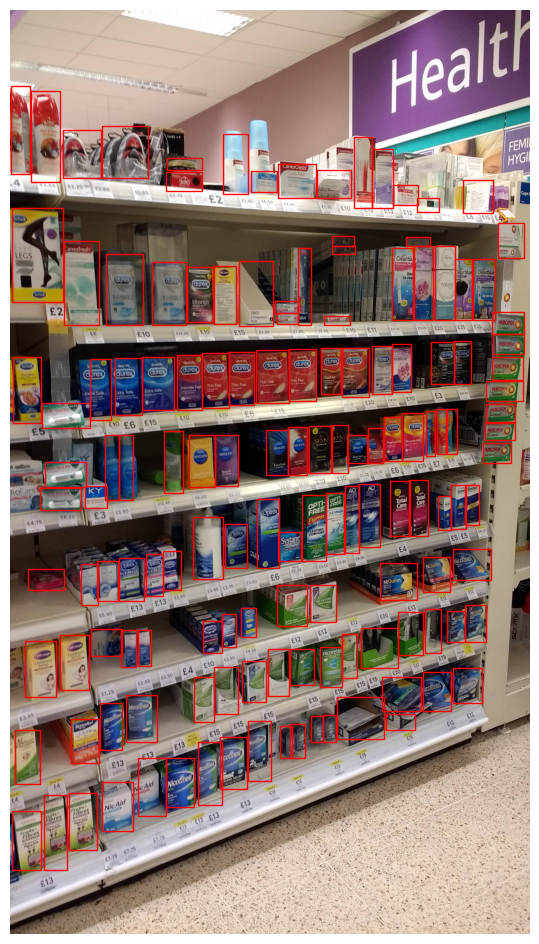

In [6]:
data_num, set = 10, 'test' 
image_num = sku_dataset_dir + rf'/images/{set}_{data_num}.jpg'
annotations_dir = Path(sku_dataset_dir) / 'annotations'
annotation_set_df = pd.read_csv("./SKU110K_fixed" + f'/annotations/annotations_{set}.csv')
annotation_num = annotation_set_df[annotation_set_df.iloc[:, 0] == f'{set}_{data_num}.jpg']

def display_image_with_annotations(image_path, annotations_df):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)

    # Add the bounding boxes
    for index, row in annotations_df.iterrows():
        x1, y1, x2, y2 = row[1], row[2], row[3], row[4]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Display the image with annotations
display_image_with_annotations(image_num, annotation_num)

## Predict
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

In [8]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow_hub as hub
import json

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

img_path = "SKU110K_fixed/images/val_110.jpg"
img = image.load_img(img_path, target_size=(416, 233))  # Adjust target_size based on the VGG19 input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

images = [
    'SKU110K_fixed/images/val_110.jpg',
    'SKU110K_fixed/images/val_116.jpg',
    'SKU110K_fixed/images/val_166.jpg',
    'SKU110K_fixed/images/val_400.jpg',
    'SKU110K_fixed/images/val_472.jpg',
]

In [9]:
def get_image_tensors(img_size, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess the image
    image_np = img.astype(np.uint8)
    image_np = np.expand_dims(image_np, axis=0)
    return img, image_np
    
def non_max_suppression(boxes, scores, score_threshold, nms_threshold):
    """
    Apply non-maximum suppression to remove overlapping bounding boxes.
    """
    # print(boxes, scores)
    indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold, nms_threshold)
    return indices.flatten()

def get_annotated_img_objects(img, boxes, scores, num_detections, score_threshold=0.15, iou_threshold=0.9, isScaled=True, max_box_size=None):
    image = np.array(img)
    objects = 0

    # Apply NMS to get the indices of the selected boxes
    selected_indices = non_max_suppression(boxes, scores, score_threshold, iou_threshold)

    print("After NMS:", len(selected_indices))

    for i in selected_indices:
        box = boxes[i]
        y_min, x_min, y_max, x_max = box

        if isScaled:
            y_min, x_min, y_max, x_max = int(y_min), int(x_min), int(y_max), int(x_max)
        else:
            # Scale coordinates to image size
            y_min = int(y_min * image.shape[0])
            x_min = int(x_min * image.shape[1])
            y_max = int(y_max * image.shape[0])
            x_max = int(x_max * image.shape[1])

        # Calculate box width and height
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Check if the box exceeds the maximum allowable size
        if max_box_size is not None and (box_width > max_box_size or box_height > max_box_size):
            continue

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        objects += 1


    return image, objects

## EfficientDet
(SSD with EfficientNet-b0 + BiFPN feature extractor, shared box predictor and focal loss), trained on COCO 2017 dataset.

In [10]:
def get_ground_truth(data_num, set):
    image_num = sku_dataset_dir + rf'/images/{set}_{data_num}.jpg'
    annotations_dir = Path(sku_dataset_dir) / 'annotations'
    annotation_set_df = pd.read_csv("./SKU110K_fixed" + f'/annotations/annotations_{set}.csv')
    annotation_num = annotation_set_df[annotation_set_df.iloc[:, 0] == f'{set}_{data_num}.jpg']
    numpy_array = annotation_num.iloc[:, 1:4].to_numpy()
    return numpy_array

def convert_to_coco_format(ground_truth, prediction, image_id=1, category_id=1):
   # Initialize the list of bounding boxes in COCO format
   ground_truth_coco_format = []
   prediction_coco_format = []

   # Convert the ground truth bounding boxes
   for i, bbox in enumerate(ground_truth):
       x1, y1, x2, y2 = bbox
       width = x2 - x1
       height = y2 - y1
       area = width * height
       ground_truth_coco_format.append({'bbox': [x1, y1, width, height], 'area': area, 'category_id': category_id, 'id': i+1, 'image_id': image_id})

   # Convert the prediction bounding boxes
   for i, bbox in enumerate(prediction):
       x1, y1, x2, y2 = bbox
       width = x2 - x1
       height = y2 - y1
       area = width * height
       prediction_coco_format.append({'bbox': [x1, y1, width, height], 'area': area, 'category_id': category_id, 'id': i+1, 'image_id': image_id})

   return ground_truth_coco_format, prediction_coco_format


        val_0.jpg     5  1429   219  1612  object  2336  4160
2873  val_116.jpg  1430  2549  1838  2626  object  2448  3264
2874  val_116.jpg  1874  2425  2284  2517  object  2448  3264
2875  val_116.jpg  1858  2533  2295  2628  object  2448  3264
2876  val_116.jpg   112  1970   525  2049  object  2448  3264
2877  val_116.jpg   124  2061   525  2143  object  2448  3264
...           ...   ...   ...   ...   ...     ...   ...   ...
2943  val_116.jpg   867  1570  1318  1670  object  2448  3264
2944  val_116.jpg   831   995  1278  1100  object  2448  3264
2945  val_116.jpg   827  1103  1269  1198  object  2448  3264
2946  val_116.jpg  1286  1145  1685  1225  object  2448  3264
2947  val_116.jpg    52  1438   162  1738  object  2448  3264

[75 rows x 8 columns]
Image shape: (1, 448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)
[[3.28109741e-01 5.33813477e-01 4.25273926e+02 4.45948853e+02]
 [2.65398163e+02 3.28723145e+00 3.06502533e+02 

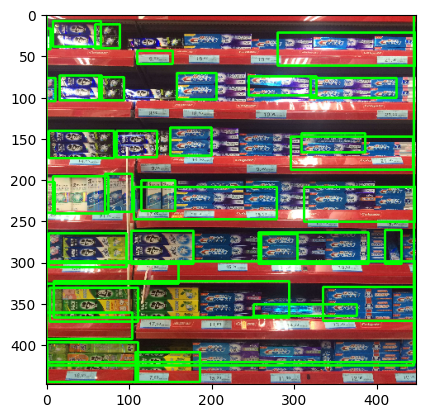

In [11]:
effdet_model = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite2/detection/1")

# Preprocess the image
img_path = "SKU110K_fixed/images/val_116.jpg"
img, image_np = get_image_tensors((448,448), img_path)

ground_truth_numpy = get_ground_truth(116,'val')

boxes, scores, classes, num_detections = effdet_model(image_np)

print("Image shape:", image_np.shape)
print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)

boxes = boxes[0].numpy()
scores = scores[0].numpy()
print(boxes)
img, objects = get_annotated_img_objects(img, boxes, scores, int(num_detections[0]), score_threshold=0.05, iou_threshold=0.8)

print("No. of objects:", objects)
print("Scores: ", scores)
plt.imshow(img)
plt.show()

Image shape: (1, 448, 448, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
After NMS: 21
No. of objects: 21


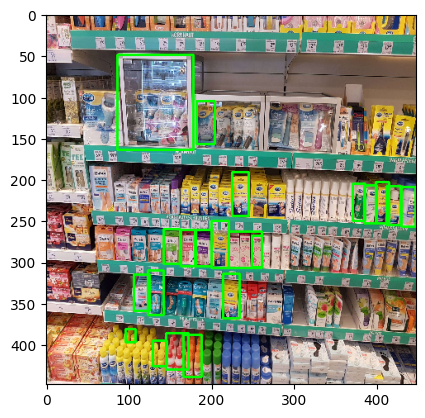

In [68]:
effdet_model2 = hub.load("https://www.kaggle.com/models/tensorflow/efficientdet/frameworks/TensorFlow2/variations/d0/versions/1")

# Preprocess the image
img_path = "SKU110K_fixed/images/val_110.jpg"
img, image_np = get_image_tensors((448,448), img_path)

# Run inference
results = effdet_model2(image_np)

# Extract relevant information
boxes = results['detection_boxes'][0].numpy()
scores = results['detection_scores'][0].numpy()
classes = results['detection_classes'][0].numpy()
num_detections = int(results['num_detections'][0].numpy())

print("Image shape:", image_np.shape)
print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)

img, objects = get_annotated_img_objects(img, boxes, scores, num_detections, score_threshold=0.1, isScaled=False)

print("No. of objects:", objects)
plt.imshow(img)
plt.show()

## RetinaNet
tensorflow/retinanet-resnet

Retinanet (SSD with Resnet 50 v1) Object detection model, trained on COCO 2017 dataset with training images scaled to 640x640.
https://www.kaggle.com/models/tensorflow/retinanet-resnet/frameworks/tensorFlow2/variations/152-v1-fpn-1024x1024

Model Result Shapes: (100, 4) (100,) (100,) 100
After NMS: 88
No. of objects: 77


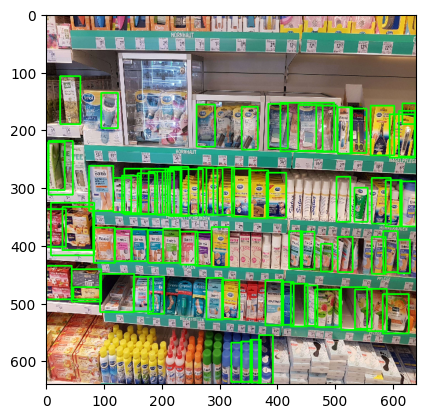

In [65]:
detector = hub.load("https://kaggle.com/models/tensorflow/retinanet-resnet/frameworks/TensorFlow2/variations/50-v1-fpn-640x640/versions/1")

# Preprocess the image
img_path = "SKU110K_fixed/images/val_110.jpg"
img, image_tensor = get_image_tensors((640,640), img_path)

# Apply image detector
detector_output = detector(image_tensor)

# Extract relevant information
boxes = detector_output["detection_boxes"][0].numpy()
scores = detector_output["detection_scores"][0].numpy()
class_ids = detector_output["detection_classes"][0].numpy()
num_detections = int(detector_output["num_detections"].numpy())

print("Model Result Shapes:", boxes.shape, scores.shape, class_ids.shape, num_detections)

img, objects = get_annotated_img_objects(img, boxes, scores, int(num_detections), score_threshold=0.1, isScaled=False, max_box_size=100)

print("No. of objects:", objects)
plt.imshow(img)
plt.show()

## Faster R-CNN
tensorflow/faster-rcnn-inception-resnet-v2

Faster R-CNN with Resnet V2 Object detection model, trained on COCO 2017 dataset with trainning images scaled to 640x640.
https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/frameworks/tensorFlow2/variations/640x640/versions/1

Model Result Shapes: (100, 4) (100,) (100,) 100
After NMS: 26
No. of objects: 23


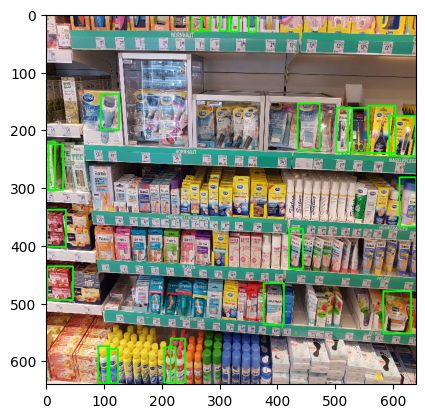

In [67]:
detector = hub.load("https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/frameworks/TensorFlow2/variations/640x640/versions/1")

# Preprocess the image
img_path = "SKU110K_fixed/images/val_110.jpg"
img, image_tensor = get_image_tensors((640,640), img_path)


# Apply image detector
detector_output = detector(image_tensor)

# Extract relevant information
boxes = detector_output["detection_boxes"][0].numpy()
scores = detector_output["detection_scores"][0].numpy()
class_ids = detector_output["detection_classes"][0].numpy()
num_detections = int(detector_output["num_detections"].numpy())

print("Model Result Shapes:", boxes.shape, scores.shape, class_ids.shape, num_detections)

img, objects = get_annotated_img_objects(img, boxes, scores, int(num_detections), score_threshold=0.1, isScaled=False, max_box_size=100)

print("No. of objects:", objects)
plt.imshow(img)
plt.show()

## MobileNet_v2
tensorflow/ssd-mobilenet-v2

Object detection model trained on the COCO dataset. 
https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/tensorFlow2/variations/fpnlite-640x640

Model Result Shapes: (100, 4) (100,) (100,) 100
No. of objects: 82


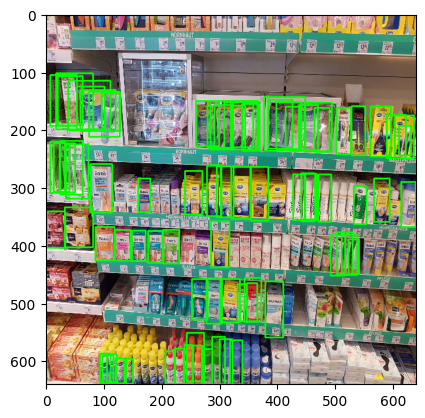

In [35]:
detector = hub.load("https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/fpnlite-640x640/versions/1")

# Preprocess the image
img_path = "SKU110K_fixed/images/val_110.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (640, 640))  # Adjust the size as needed
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_tensor = tf.convert_to_tensor([img], dtype=tf.uint8)


# Apply image detector
detector_output = detector(image_tensor)

# Extract relevant information
boxes = detector_output["detection_boxes"][0].numpy()
scores = detector_output["detection_scores"][0].numpy()
class_ids = detector_output["detection_classes"][0].numpy()
num_detections = int(detector_output["num_detections"].numpy())

print("Model Result Shapes:", boxes.shape, scores.shape, class_ids.shape, num_detections)

img, objects = get_annotated_img_objects(img, boxes, scores, int(num_detections), score_threshold=0.2, isScaled=False, max_box_size=100)

print("No. of objects:", objects)
plt.imshow(img)
plt.show()

### After NMS and score threshold finetuning

Model Result Shapes: (100, 4) (100,) (100,) 100
After NMS: 77
No. of objects: 70


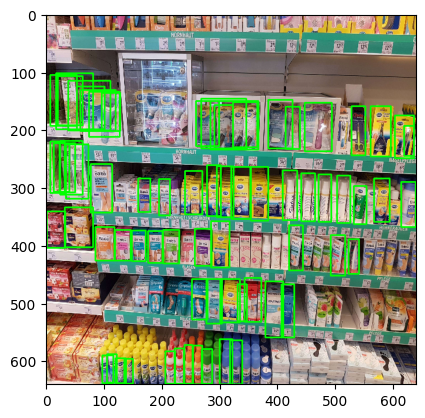

In [63]:
detector = hub.load("https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/fpnlite-640x640/versions/1")

# Preprocess the image
img_path = "SKU110K_fixed/images/val_110.jpg"
img, image_tensor = get_image_tensors((640,640), img_path)

# Apply image detector
detector_output = detector(image_tensor)

# Extract relevant information
boxes = detector_output["detection_boxes"][0].numpy()
scores = detector_output["detection_scores"][0].numpy()
class_ids = detector_output["detection_classes"][0].numpy()
num_detections = int(detector_output["num_detections"].numpy())

print("Model Result Shapes:", boxes.shape, scores.shape, class_ids.shape, num_detections)

img, objects = get_annotated_img_objects(img, boxes, scores, int(num_detections), score_threshold=0.1, iou_threshold=0.85, isScaled=False, max_box_size=100)

print("No. of objects:", objects)
plt.imshow(img)
plt.show()

In [27]:
print(scores)

[0.38388804 0.37444314 0.35767916 0.34666047 0.34565413 0.34193128
 0.32320446 0.3181602  0.31439203 0.31239745 0.29954842 0.2974
 0.289669   0.2891303  0.28750587 0.28578588 0.28219503 0.27858537
 0.27706182 0.27409574 0.27110803 0.26999974 0.26834014 0.26321593
 0.25901914 0.25880367 0.2580783  0.25795224 0.2575701  0.25576028
 0.25252384 0.25088477 0.25088164 0.24893554 0.24690737 0.24641438
 0.24521948 0.24481797 0.24389392 0.2435873  0.24142979 0.24105678
 0.24038026 0.23970899 0.23926476 0.23809549 0.23512177 0.23511232
 0.23434311 0.2333754  0.23244101 0.23171544 0.23054013 0.22989537
 0.22935109 0.22857395 0.22822225 0.22822057 0.22784017 0.22631337
 0.22431435 0.22372088 0.22212292 0.22155753 0.22152436 0.22077556
 0.22032616 0.22008541 0.22001138 0.21915063 0.21679792 0.2152869
 0.21435946 0.21402699 0.21283065 0.21203783 0.21135315 0.21109448
 0.21047796 0.20931663 0.20630983 0.20538051 0.20526195 0.20430364
 0.20314227 0.20233993 0.20199433 0.20043492 0.19957557 0.19891757
